# Google Store App Rating Prediction

## 1. Import Useful Libraries

In [1]:
# To enable plotting graphs in Jupyter notebook
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
# Import useful libraries
import pandas as pd
import numpy as np
# from colorama import Fore,Style
import time
from sklearn import preprocessing
# Accuracy and other metrics of model
from sklearn import metrics
from sklearn.metrics import average_precision_score, confusion_matrix, accuracy_score,classification_report, plot_confusion_matrix,roc_curve, auc
import seaborn as sns
sns.set(color_codes=True)
sns.set(style="darkgrid")

#For regular expressions. easy to access complicated patterns
import re

## 2. Read Data

In [3]:
# READ Google store application related dataset
# Reading the data from csv
DF=pd.read_csv("Apps_data2.csv")

TBLUE = '\033[30;1;42m' # Blue Text, Green background
TRED =  '\033[31m'
TGREEN = '\033[32m'

# Check size
if DF.size<10000:
    print(TGREEN +"\nDataset is small")
elif DF.size>10000 and DF.size<50000:
    print(TGREEN+"\nDataset is Medium")
else:
    print(TBLUE+"\nDataset is LARGE")

# Auto Detect feature size
print(TRED+"\nNumber of features",DF.shape[1])


Dataset is LARGE

Number of features 13


In [4]:
# to display the dimension of the dataframe
#Depth vs breadth Analysis : The number of datapoints(Rows) vs number of features(Columns)
DF.shape
print (TBLUE + "Data Shape:", DF.shape,"\nData Size:", DF.size)

Data Shape: (10841, 13) 
Data Size: 140933


## 3.  Data Analysis and Preparation

# Total number of data points are  10841  we have 13 columns.


### Manual inspection observation

#### Manual inspection suggests there are a few Nan values and blank cells present throghout dataset.

In [5]:
# # Print the top n values of the dataset
# It is advisable to get to know your data very well.Always manually inspect data yourself.
DF.head(10)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up
5,Paper flowers instructions,ART_AND_DESIGN,4.4,167,5.6M,"50,000+",Free,0,Everyone,Art & Design,"March 26, 2017",1.0,2.3 and up
6,Smoke Effect Photo Maker - Smoke Editor,ART_AND_DESIGN,3.8,178,19M,"50,000+",Free,0,Everyone,Art & Design,"April 26, 2018",1.1,4.0.3 and up
7,Infinite Painter,ART_AND_DESIGN,4.1,36815,29M,"1,000,000+",Free,0,Everyone,Art & Design,"June 14, 2018",6.1.61.1,4.2 and up
8,Garden Coloring Book,ART_AND_DESIGN,4.4,13791,33M,"1,000,000+",Free,0,Everyone,Art & Design,"September 20, 2017",2.9.2,3.0 and up
9,Kids Paint Free - Drawing Fun,ART_AND_DESIGN,4.7,121,3.1M,"10,000+",Free,0,Everyone,Art & Design;Creativity,"July 3, 2018",2.8,4.0.3 and up


### Check the info and summary statistics of the dataset

In [6]:
DF['Size'].describe()

count                  10841
unique                   462
top       Varies with device
freq                    1695
Name: Size, dtype: object

#### Size is a variable which depends on device/handset as most application size are of kind "Varies with device"

#### Basic visual analysis of data shows long ranges in many columns including number of Reviews and Number of installations done  for each applications such as games, photo editing and other applications. All the data points are as expected and does not seem to have any problems except one row in which some data is shifted by one or two columns

### b. Check if there are any duplicate entries for the apps (1 point)

In [7]:
DFF = DF[DF.duplicated()]
DFF.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
229,Quick PDF Scanner + OCR FREE,BUSINESS,4.2,80805,Varies with device,"5,000,000+",Free,0,Everyone,Business,"February 26, 2018",Varies with device,4.0.3 and up
236,Box,BUSINESS,4.2,159872,Varies with device,"10,000,000+",Free,0,Everyone,Business,"July 31, 2018",Varies with device,Varies with device
239,Google My Business,BUSINESS,4.4,70991,Varies with device,"5,000,000+",Free,0,Everyone,Business,"July 24, 2018",2.19.0.204537701,4.4 and up
256,ZOOM Cloud Meetings,BUSINESS,4.4,31614,37M,"10,000,000+",Free,0,Everyone,Business,"July 20, 2018",4.1.28165.0716,4.0 and up
261,join.me - Simple Meetings,BUSINESS,4.0,6989,Varies with device,"1,000,000+",Free,0,Everyone,Business,"July 16, 2018",4.3.0.508,4.4 and up


#### Obsevration :total 5 BUSINESS category app entries are duplicated in the dataset. So dropping duplicates

In [8]:
# dropping duplicate values 
DF.drop_duplicates(keep=False,inplace=True) 

### in the ‘Category’ column there are some shifted values found, it is corrected later.

## 4. Descriptive Statistics

In [9]:
DF.dtypes

App                object
Category           object
Rating            float64
Reviews            object
Size               object
Installs           object
Type               object
Price              object
Content Rating     object
Genres             object
Last Updated       object
Current Ver        object
Android Ver        object
dtype: object

In [10]:
# DF.describe().transpose()
DF.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Rating,8491.0,4.186032,0.552493,1.0,4.0,4.3,4.5,19.0


#### Few Observations:
1. From the above output, we see that except for the columns of Rating, each column in given dataset is object type.
2. None of the algorithms can work on object datatype. So we need to convert dataType to category. Categories are internally stored as numbers

#### Numerical columns - Rating
3. Remaining columns are object

[]

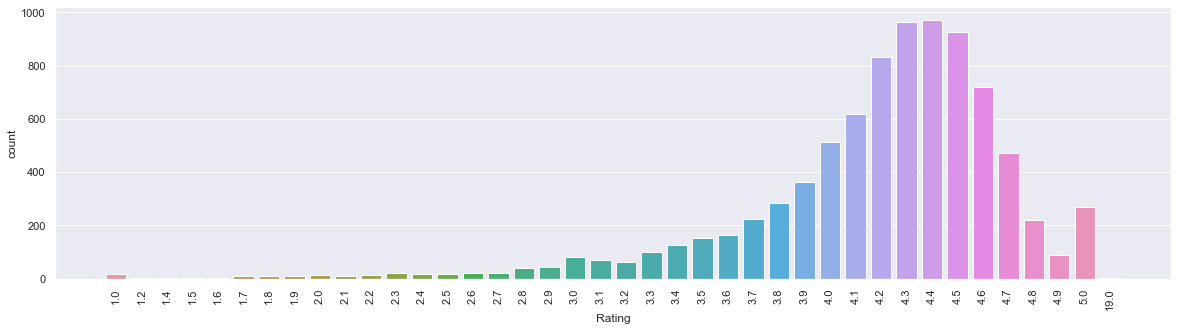

In [11]:
# Below plot shows the different brand names and no of phones 
plt.figure(figsize=(20,5))
sns.countplot(x=DF['Rating'])
plt.xticks(rotation=90)
plt.plot()

#### Observation : Target comuln is not normally distributed.

## Data Preparation:
#### Missing value treatment


In [12]:
# Missing value treatment

print(TGREEN+"\nMissing or null values:")
print(DF.isnull().sum())

#Let us see if we can get those records with nan
#Option 2
#DF[DF.isnull().any(axis=1)]


Missing or null values:
App                  0
Category             0
Rating            1457
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       1
Genres               0
Last Updated         0
Current Ver          8
Android Ver          3
dtype: int64


## Prepare Target Column

In [13]:
# Data cleansing/create classes for Target Variable as target variable is object type
DF['Rating'].replace(np.nan,0,inplace=True)
n=2
Target_column = 'Rating'

print("Unique values and frequency pre cleansing:\n", DF[Target_column].value_counts())

for i in range(len(DF[Target_column])):
    ratingVal = (DF.iloc[i,n])
    if ratingVal >= 3.5:
        DF.iloc[i,n]= 1.0 #'HIGH'
    else:
        DF.iloc[i,n]= 0.0 #'LOW'
    
print("\n\nUnique values and frequency post cleansing:\n",DF[Target_column].value_counts())  


Unique values and frequency pre cleansing:
 0.0     1457
4.4      972
4.3      963
4.5      925
4.2      834
4.6      720
4.1      617
4.0      514
4.7      470
3.9      361
3.8      284
5.0      268
3.7      224
4.8      222
3.6      164
3.5      151
3.4      126
3.3      100
4.9       87
3.0       81
3.1       69
3.2       64
2.9       45
2.8       39
2.6       23
2.7       21
2.3       20
2.4       19
2.5       19
1.0       16
2.2       14
2.0       12
1.9       11
1.7        8
1.8        8
2.1        8
1.6        4
1.5        3
1.4        3
19.0       1
1.2        1
Name: Rating, dtype: int64


Unique values and frequency post cleansing:
 1.0    7777
0.0    2171
Name: Rating, dtype: int64


### Mising values present are in the columns: Rating, Content Rating, Current Ver and Androdi Version

In [14]:
# Auto detect continuous and categorical featured

Summary=DF.describe().T
Conti=Summary.index
Column_name=DF.columns
All=[]
for i in range(len(Conti)):
    for j in range(len(Column_name)):
        if Conti[i]!=Column_name[j]:
            All.append(Column_name[j])
Categorical=list(set(All)-set(Conti))
Continuous=list(set(All)-set(Categorical))
print(TGREEN+"Continuous Variables:",TRED+"",Continuous)
print(TGREEN+"\nCategorical variables found in the dataset:\n",TRED+"",Categorical)

Continuous Variables:  []

Categorical variables found in the dataset:
  ['Installs', 'Last Updated', 'Current Ver', 'App', 'Type', 'Category', 'Price', 'Android Ver', 'Size', 'Content Rating', 'Reviews', 'Genres']


## Data cleansing and preparation

### Convert the ‘Review’ column to a numerical column and impute invalid values if there are any.Its having shifted values 

In [15]:
# DF['Reviews'].astype('int')
n =3
for i in range(len(DF['Reviews'])):
    ratingVal = (DF.iloc[i,n])
    if ratingVal == '3.0M':
        DF = DF.drop(DF.index[i])
        break

In [16]:
DF['Reviews']= DF.Reviews.astype('int64')

### Prepare Size Column

### h. Make the values of ‘Size’ as integers by replacing M and K with correct values. Convert all the values to numeric and make invalid values to NaN.

In [17]:
DF['ActualSize'] = 0
DF['ActualSize']= DF.ActualSize.astype('float64')
DF.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,ActualSize
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,1.0,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up,0.0
1,Coloring book moana,ART_AND_DESIGN,1.0,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up,0.0
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,1.0,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up,0.0
3,Sketch - Draw & Paint,ART_AND_DESIGN,1.0,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up,0.0
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,1.0,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up,0.0


In [18]:
n =4 #Size column
i = 0
for i in range(len(DF['Size'])):
    size = (DF.iloc[i,n])
    extractsize = re.findall(r"[-+]?\d*\.\d+|\d+",size)
#     print(extractsize) 
    if 'M' in size:
        DF.iloc[i,n] = extractsize
    if 'k' in size:
        DF.iloc[i,n] = extractsize
    if '+' in size:
        DF.iloc[i,n] = extractsize
    if 'Varies with device' in size:
        DF.iloc[i,n] = 0
DF['Size']= DF.Size.astype('float64')

In [41]:
DF.head()

Rating                          category
Reviews                            int64
Size                             float64
Installs                         float64
Price                            float64
ActualSize                       float64
Type_Free                          uint8
Type_Paid                          uint8
Category_ART_AND_DESIGN            uint8
Category_AUTO_AND_VEHICLES         uint8
Category_BEAUTY                    uint8
Category_BOOKS_AND_REFERENCE       uint8
Category_BUSINESS                  uint8
Category_COMICS                    uint8
Category_COMMUNICATION             uint8
Category_DATING                    uint8
Category_EDUCATION                 uint8
Category_ENTERTAINMENT             uint8
Category_EVENTS                    uint8
Category_FAMILY                    uint8
Category_FINANCE                   uint8
Category_FOOD_AND_DRINK            uint8
Category_GAME                      uint8
Category_HEALTH_AND_FITNESS        uint8
Category_HOUSE_A

### i. Remove “,” and “+” from the values of the “Installs” column and change the datatype.

In [20]:
n =5 #Installs column
i = 0
#Removing punctuations
DF['Installs'] = DF['Installs'].str.replace('[^\w\s]','')
DF['Installs'].head(20)
DF['Installs']= DF.Installs.astype('float64')
# for i in range(len(DF['Installs'])):
#     installation = (DF.iloc[i,n])
#     extractInstalls = re.findall(r"[-+]?\d*\.\d+|\d+",installation)
#     print(extractInstalls)
#     extractInstalls = extractInstalls.replace(',', '')
#     print(extractInstalls)
#     DF.iloc[i,n] = extractInstalls

### k. Remove the “$” sign the “Price” column values and make it a numerical column.

In [21]:
n =7 #Price column
i = 0
for i in range(len(DF['Price'])):
    price = (DF.iloc[i,n])
    extractprice = re.findall(r"[-+]?\d*\.\d+|\d+",price)
    DF.iloc[i,n] = extractprice

In [22]:
DF['Price']= DF.Price.astype('float64')
DF.dtypes

App                object
Category           object
Rating            float64
Reviews             int64
Size              float64
Installs          float64
Type               object
Price             float64
Content Rating     object
Genres             object
Last Updated       object
Current Ver        object
Android Ver        object
ActualSize        float64
dtype: object

### n. Encode categorical column (Type, Rating_categories, Category) [ Hint -use get_dummies] 
### As Machine learning algorithms don't work with string data, we convert it into Numbers using use get dummies

In [23]:
# Data cleansing/create classes for Target Variable : develop class varification

dummies_column = ['Type','Category']
DF = pd.get_dummies(DF,columns=dummies_column)


### Drop columns :These features may not be affecting the rating such as Name of the App and few others so droppping them
App, Content Rating, Genre, Last updated, Current Ver, and Android Ver
columns from the final data frame. 

In [24]:
DF = DF.drop(['App','Content Rating','Genres'],axis=1)
DF = DF.drop('Last Updated',axis=1)
DF = DF.drop('Current Ver',axis=1)
DF = DF.drop('Android Ver',axis=1)
DF.head(1)

,Rating,Reviews,Size,Installs,Price,ActualSize,Type_Free,Type_Paid,Category_ART_AND_DESIGN,Category_AUTO_AND_VEHICLES,...,Category_PERSONALIZATION,Category_PHOTOGRAPHY,Category_PRODUCTIVITY,Category_SHOPPING,Category_SOCIAL,Category_SPORTS,Category_TOOLS,Category_TRAVEL_AND_LOCAL,Category_VIDEO_PLAYERS,Category_WEATHER
0,1.0,159,19.0,10000.0,0.0,0.0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


#### All relavant clumns are of numerical dataTypes. Check 5 point summary for each features.

In [25]:
DF.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Rating,9947.0,7.817432e-01,4.130834e-01,0.0,1.0,1.0,1.0,1.000000e+00
Reviews,9947.0,3.659332e+05,2.412615e+06,0.0,29.0,1387.0,41374.5,7.815831e+07
Size,9947.0,3.225219e+01,9.503209e+01,0.0,3.3,10.0,29.0,1.020000e+03
Installs,9947.0,1.286208e+07,7.502973e+07,0.0,1000.0,100000.0,1000000.0,1.000000e+09
Price,9947.0,1.027578e+00,1.657140e+01,0.0,0.0,0.0,0.0,4.000000e+02
ActualSize,9947.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00
Type_Free,9947.0,9.264100e-01,2.611157e-01,0.0,1.0,1.0,1.0,1.000000e+00
Type_Paid,9947.0,7.348949e-02,2.609514e-01,0.0,0.0,0.0,0.0,1.000000e+00
Category_ART_AND_DESIGN,9947.0,6.534634e-03,8.057658e-02,0.0,0.0,0.0,0.0,1.000000e+00
Category_AUTO_AND_VEHICLES,9947.0,8.545290e-03,9.204955e-02,0.0,0.0,0.0,0.0,1.000000e+00


In [26]:
# Visualizing Column: Rating

# Target is imbalanced

brands=DF['Rating'].value_counts()
print(TGREEN+"Rating has",len(brands),"unique values")
DF['Rating'].value_counts()

Rating has 2 unique values


1.0    7776
0.0    2171
Name: Rating, dtype: int64

#### Target is encoded into 2 values

### 1.0 - HIGH rating and 0.0 - LOW rating

In [27]:
DF['Rating']= DF.Rating.astype('category')
DF.dtypes

Rating                          category
Reviews                            int64
Size                             float64
Installs                         float64
Price                            float64
ActualSize                       float64
Type_Free                          uint8
Type_Paid                          uint8
Category_ART_AND_DESIGN            uint8
Category_AUTO_AND_VEHICLES         uint8
Category_BEAUTY                    uint8
Category_BOOKS_AND_REFERENCE       uint8
Category_BUSINESS                  uint8
Category_COMICS                    uint8
Category_COMMUNICATION             uint8
Category_DATING                    uint8
Category_EDUCATION                 uint8
Category_ENTERTAINMENT             uint8
Category_EVENTS                    uint8
Category_FAMILY                    uint8
Category_FINANCE                   uint8
Category_FOOD_AND_DRINK            uint8
Category_GAME                      uint8
Category_HEALTH_AND_FITNESS        uint8
Category_HOUSE_A

In [28]:
# Let us look at the target column which is 'Rating' to understand how the data is distributed amongst 
#the various values
DF.groupby(["Rating"]).count()

,Reviews,Size,Installs,Price,ActualSize,Type_Free,Type_Paid,Category_ART_AND_DESIGN,Category_AUTO_AND_VEHICLES,Category_BEAUTY,...,Category_PERSONALIZATION,Category_PHOTOGRAPHY,Category_PRODUCTIVITY,Category_SHOPPING,Category_SOCIAL,Category_SPORTS,Category_TOOLS,Category_TRAVEL_AND_LOCAL,Category_VIDEO_PLAYERS,Category_WEATHER
Rating,,,,,,,,,,,,,,,,,,,,,
0.0,2171,2171,2171,2171,2171,2171,2171,2171,2171,2171,...,2171,2171,2171,2171,2171,2171,2171,2171,2171,2171
1.0,7776,7776,7776,7776,7776,7776,7776,7776,7776,7776,...,7776,7776,7776,7776,7776,7776,7776,7776,7776,7776


#### Out of 10841 records, 7000+ records belong to class 1 [HIGH] ,2171 belong to class 0 [LOW]


### Let us check whether any of the columns has any value other than numeric i.e. data is not corrupted such as a "?" instead of a number.

In [29]:
# Let us check whether any of the columns has any value other than numeric i.e. data is not corrupted such as a "?" instead of 
# a number.

# we use np.isreal a numpy function which checks each column for each row and returns a bool array, 
# where True if input element is real.
# applymap is pandas dataframe function that applies the np.isreal function columnwise
# Following line selects those rows which have some non-numeric value in any of the columns hence the  ~ symbol

DF[~DF.applymap(np.isreal).all(1)]

,Rating,Reviews,Size,Installs,Price,ActualSize,Type_Free,Type_Paid,Category_ART_AND_DESIGN,Category_AUTO_AND_VEHICLES,...,Category_PERSONALIZATION,Category_PHOTOGRAPHY,Category_PRODUCTIVITY,Category_SHOPPING,Category_SOCIAL,Category_SPORTS,Category_TOOLS,Category_TRAVEL_AND_LOCAL,Category_VIDEO_PLAYERS,Category_WEATHER


### None of the columns have invalid values or Nan

In [30]:
# to display the column names of the dataframe
DF.columns

Index(['Rating', 'Reviews', 'Size', 'Installs', 'Price', 'ActualSize',
       'Type_Free', 'Type_Paid', 'Category_ART_AND_DESIGN',
       'Category_AUTO_AND_VEHICLES', 'Category_BEAUTY',
       'Category_BOOKS_AND_REFERENCE', 'Category_BUSINESS', 'Category_COMICS',
       'Category_COMMUNICATION', 'Category_DATING', 'Category_EDUCATION',
       'Category_ENTERTAINMENT', 'Category_EVENTS', 'Category_FAMILY',
       'Category_FINANCE', 'Category_FOOD_AND_DRINK', 'Category_GAME',
       'Category_HEALTH_AND_FITNESS', 'Category_HOUSE_AND_HOME',
       'Category_LIBRARIES_AND_DEMO', 'Category_LIFESTYLE',
       'Category_MAPS_AND_NAVIGATION', 'Category_MEDICAL',
       'Category_NEWS_AND_MAGAZINES', 'Category_PARENTING',
       'Category_PERSONALIZATION', 'Category_PHOTOGRAPHY',
       'Category_PRODUCTIVITY', 'Category_SHOPPING', 'Category_SOCIAL',
       'Category_SPORTS', 'Category_TOOLS', 'Category_TRAVEL_AND_LOCAL',
       'Category_VIDEO_PLAYERS', 'Category_WEATHER'],
      dtype='obj

# 5. Univariate Analysis and Pairplots

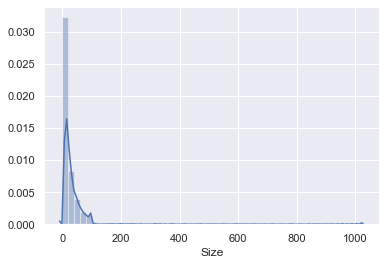

In [31]:
sns.distplot(DF['Size']);

In [42]:
DF['Rating']= DF.Rating.astype('float64')

#### Size doesnt have normal distribution

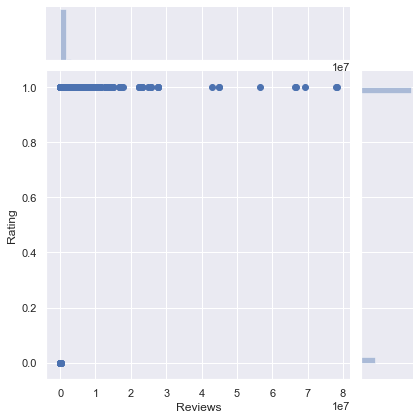

In [33]:
sns.jointplot(DF['Reviews'], DF['Rating']);

### Number of Reviews are higher for the app with a 'HIGH; rating (in the Target Column)

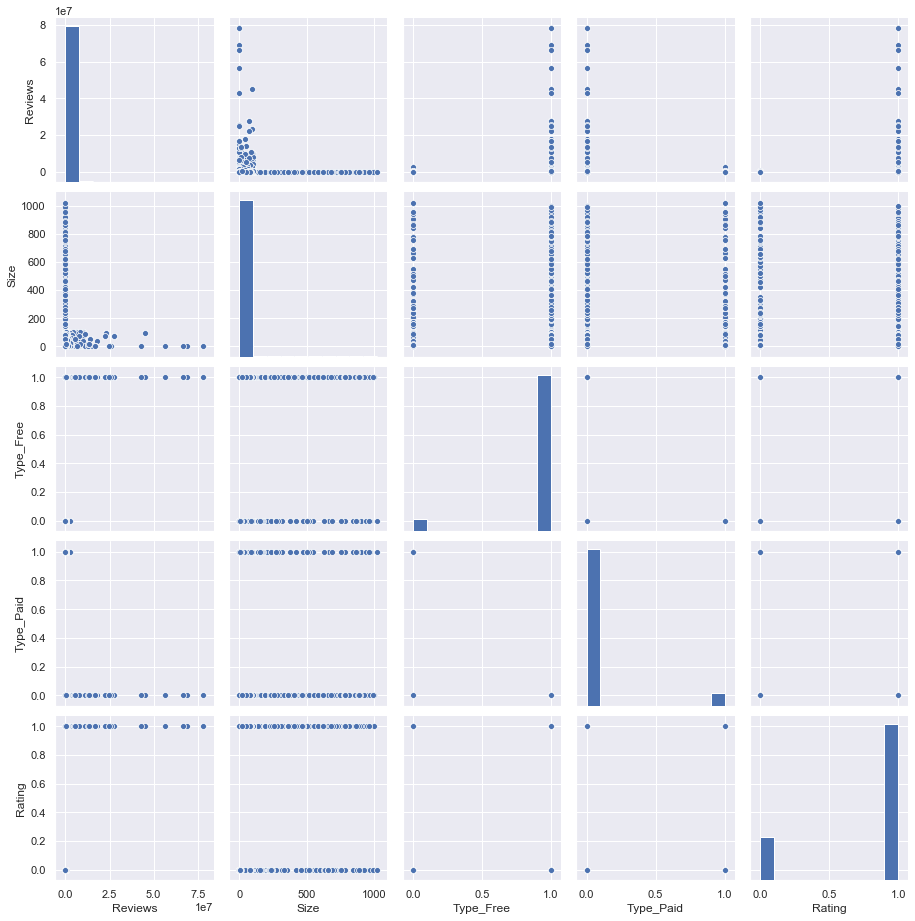

In [34]:
sns.pairplot(DF, vars = ["Reviews","Size","Type_Free","Type_Paid","Rating"]);
# to plot density curve instead of histogram
# sns.pairplot(DF, vars = ["Reviews","Size"],diag_kind='kde');
# to plot density curve instead of histogram

## 6. Data Preparation

In [35]:
### Target Column separation

In [36]:
#decide your regressor and predictor variables
# # separate final dataset from Target column
Target_column='Rating'
#First create a separate dataframe
DF_cleansed = DF.drop(Target_column,axis=1)
Target=DF[Target_column]

### most of the data is not Normally distributed

## 6 Correlation

In [43]:
# To get a correlation matrix 
corr = DF.corr() 

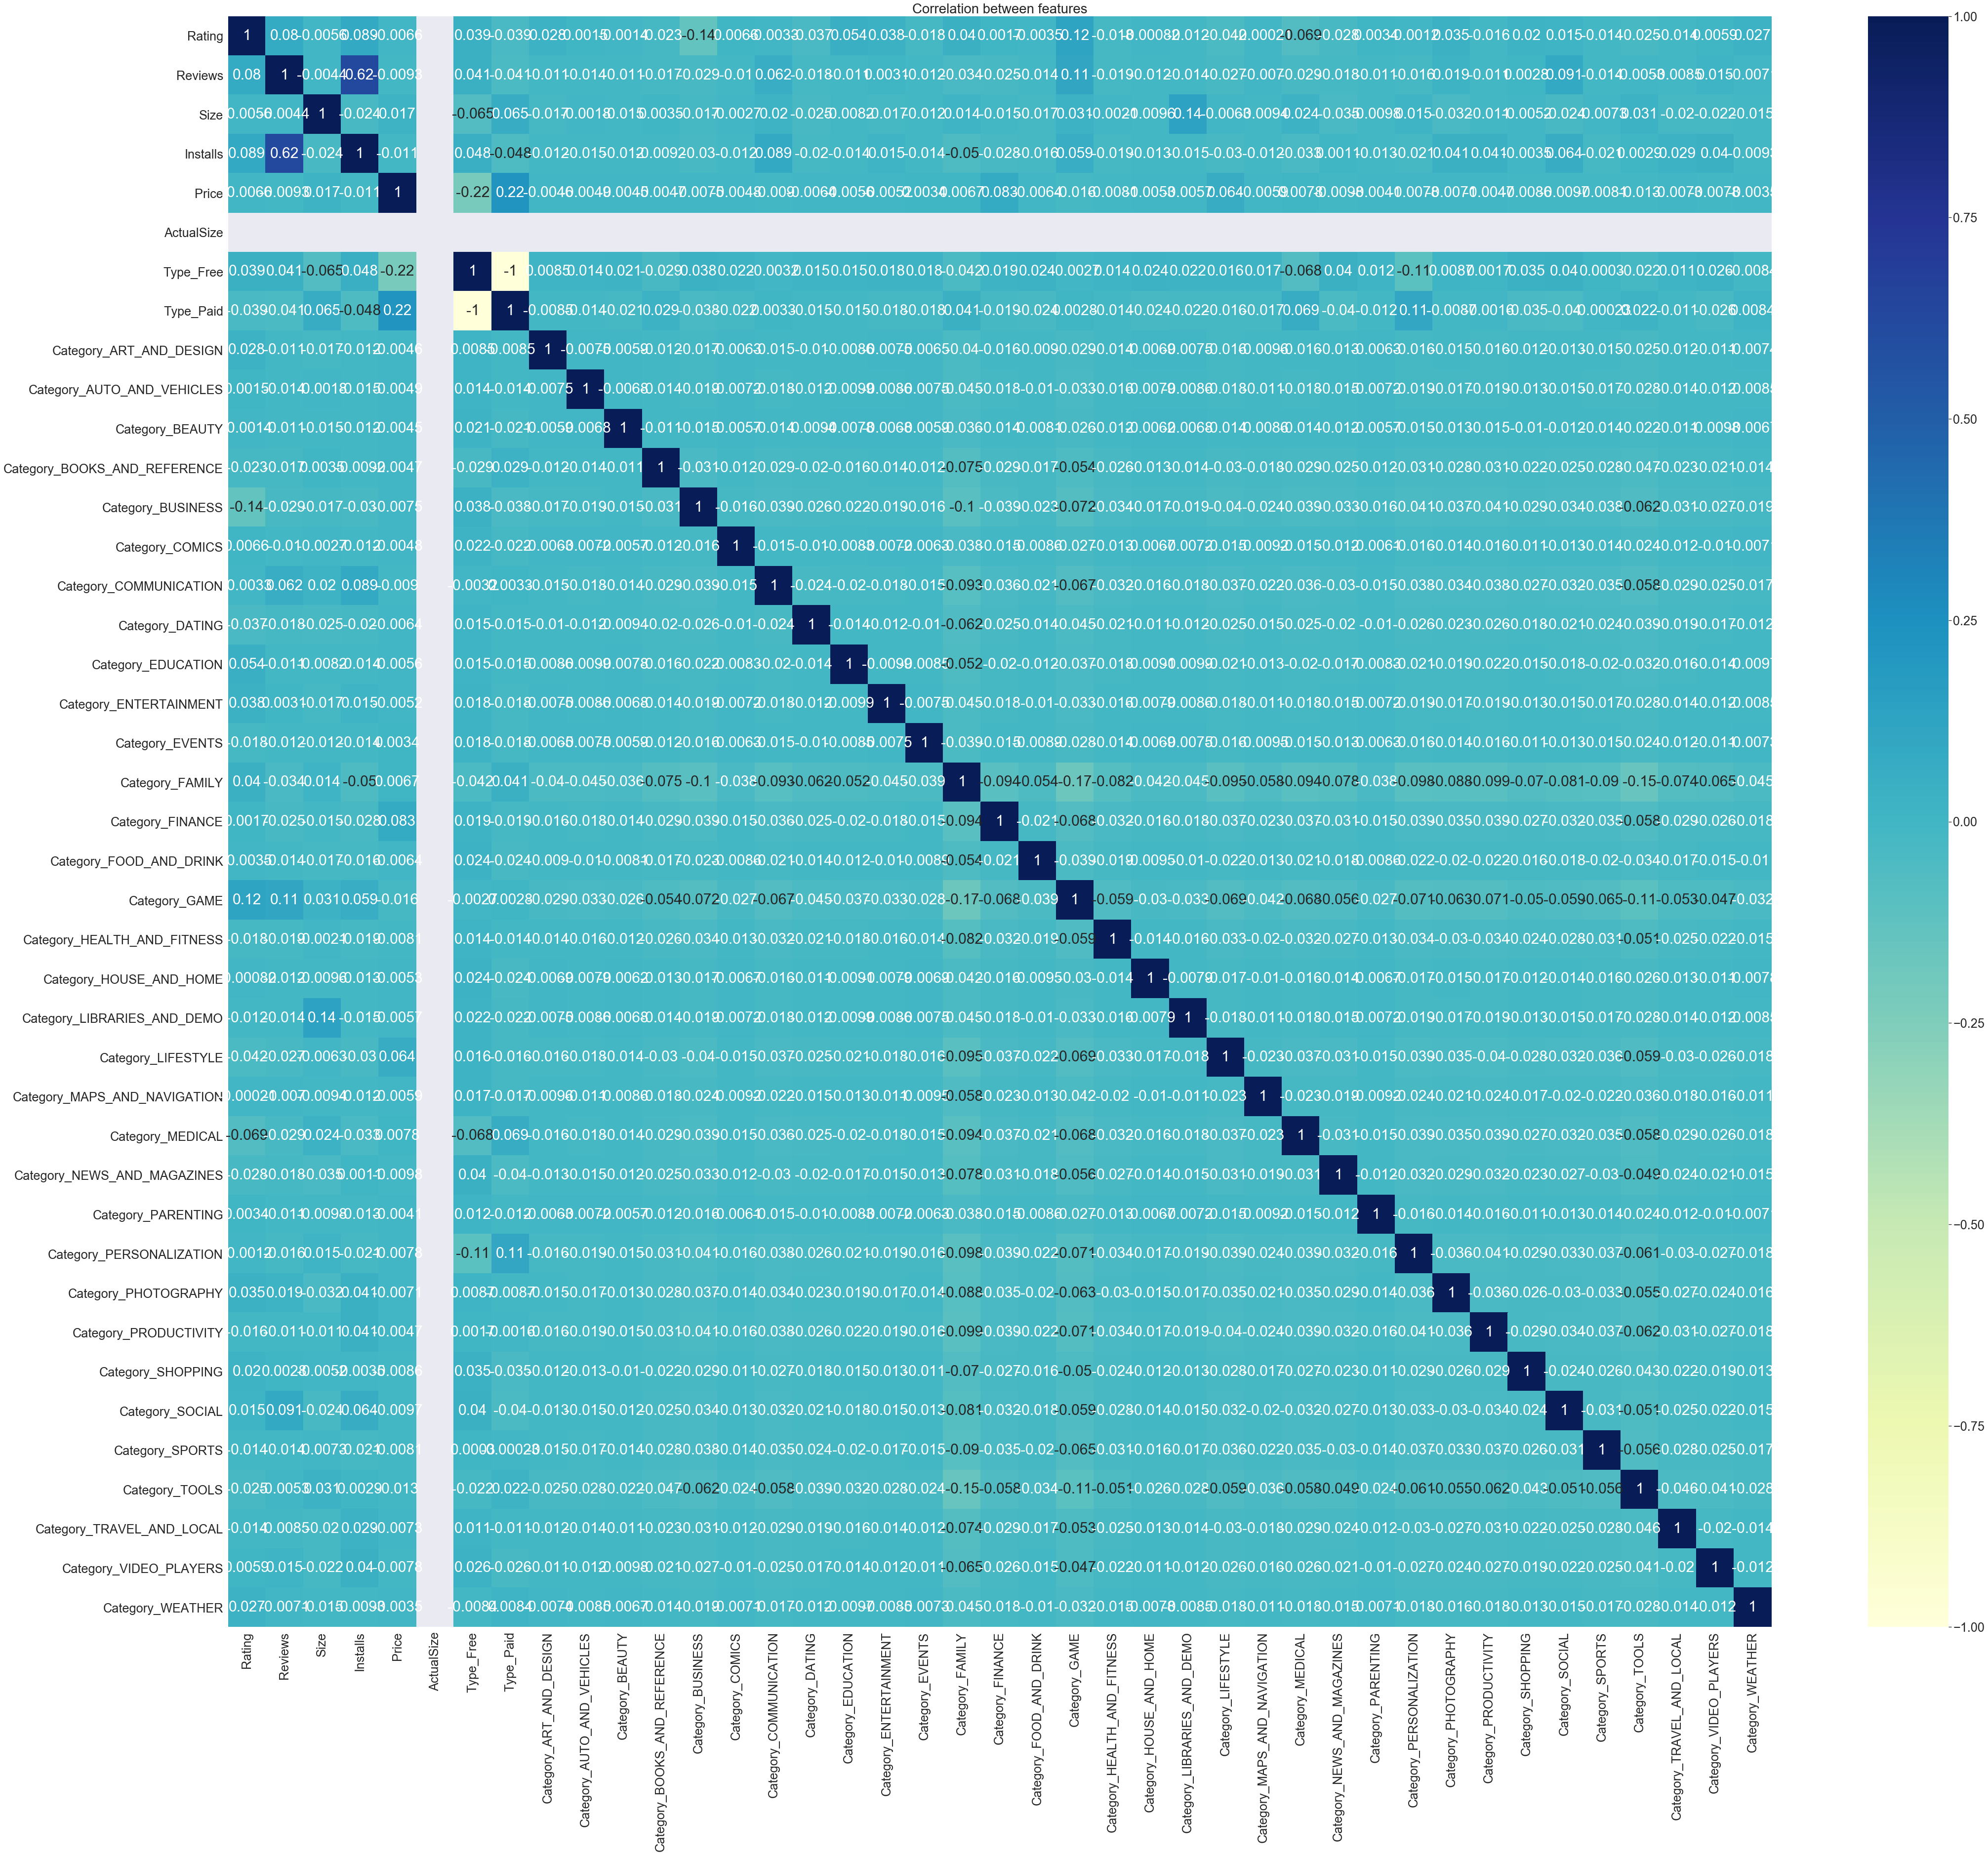

In [46]:
# Ploting correlation plot

plt.figure(figsize=(70, 60))

# plotting the heat map
# corr: give the correlation matrix
# cmap: colour code used for plotting
# vmax: gives maximum range of values for the chart
# vmin: gives minimum range of values for the chart
# annot: prints the correlation values in the chart
# annot_kws={"size": 12}): Sets the font size of the annotation
sns.set(font_scale=2.3)
sns.heatmap(corr, cmap='YlGnBu', vmax=1.0, vmin=-1.0, annot = True, annot_kws={"size": 30})

# specify name of the plot
plt.title('Correlation between features')
plt.show()

In [47]:
DF.head()

,Rating,Reviews,Size,Installs,Price,ActualSize,Type_Free,Type_Paid,Category_ART_AND_DESIGN,Category_AUTO_AND_VEHICLES,...,Category_PERSONALIZATION,Category_PHOTOGRAPHY,Category_PRODUCTIVITY,Category_SHOPPING,Category_SOCIAL,Category_SPORTS,Category_TOOLS,Category_TRAVEL_AND_LOCAL,Category_VIDEO_PLAYERS,Category_WEATHER
0,1.0,159,19.0,10000.0,0.0,0.0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1.0,967,14.0,500000.0,0.0,0.0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,87510,8.7,5000000.0,0.0,0.0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1.0,215644,25.0,50000000.0,0.0,0.0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,967,2.8,100000.0,0.0,0.0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


### Observations
    Note: Correlation is considered higher as a value gets close to 1.
1. Review has a high correlation with Installs
4. Medical apps are highly priced. as correlatin graph shows high relation betweeen Price_paid and category_medical.

In [48]:
DF.columns

Index(['Rating', 'Reviews', 'Size', 'Installs', 'Price', 'ActualSize',
       'Type_Free', 'Type_Paid', 'Category_ART_AND_DESIGN',
       'Category_AUTO_AND_VEHICLES', 'Category_BEAUTY',
       'Category_BOOKS_AND_REFERENCE', 'Category_BUSINESS', 'Category_COMICS',
       'Category_COMMUNICATION', 'Category_DATING', 'Category_EDUCATION',
       'Category_ENTERTAINMENT', 'Category_EVENTS', 'Category_FAMILY',
       'Category_FINANCE', 'Category_FOOD_AND_DRINK', 'Category_GAME',
       'Category_HEALTH_AND_FITNESS', 'Category_HOUSE_AND_HOME',
       'Category_LIBRARIES_AND_DEMO', 'Category_LIFESTYLE',
       'Category_MAPS_AND_NAVIGATION', 'Category_MEDICAL',
       'Category_NEWS_AND_MAGAZINES', 'Category_PARENTING',
       'Category_PERSONALIZATION', 'Category_PHOTOGRAPHY',
       'Category_PRODUCTIVITY', 'Category_SHOPPING', 'Category_SOCIAL',
       'Category_SPORTS', 'Category_TOOLS', 'Category_TRAVEL_AND_LOCAL',
       'Category_VIDEO_PLAYERS', 'Category_WEATHER'],
      dtype='obj

In [49]:
DF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9947 entries, 0 to 10840
Data columns (total 41 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Rating                        9947 non-null   float64
 1   Reviews                       9947 non-null   int64  
 2   Size                          9947 non-null   float64
 3   Installs                      9947 non-null   float64
 4   Price                         9947 non-null   float64
 5   ActualSize                    9947 non-null   float64
 6   Type_Free                     9947 non-null   uint8  
 7   Type_Paid                     9947 non-null   uint8  
 8   Category_ART_AND_DESIGN       9947 non-null   uint8  
 9   Category_AUTO_AND_VEHICLES    9947 non-null   uint8  
 10  Category_BEAUTY               9947 non-null   uint8  
 11  Category_BOOKS_AND_REFERENCE  9947 non-null   uint8  
 12  Category_BUSINESS             9947 non-null   uint8  
 13  Ca

## 7 Discover Outliers with Visualization

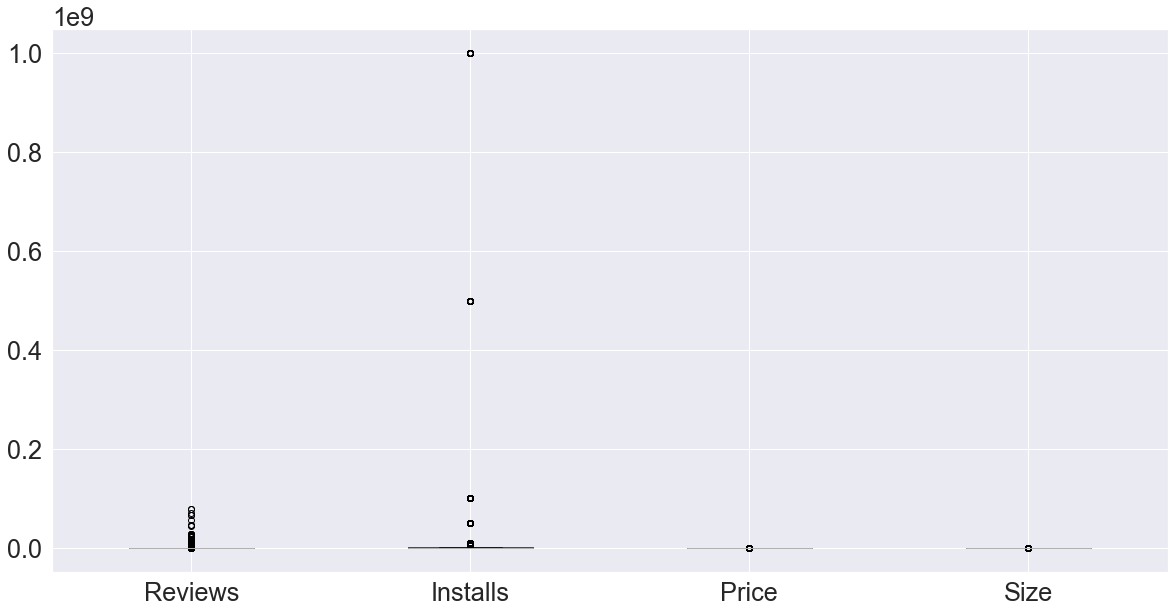

In [50]:
# create a boxplot for all the continuous features
DF.boxplot(column = ['Reviews','Installs','Price','Size'], figsize = (20,10))

### There are not too many outliars present.

# Build Model

In [51]:
# 1. Logistic Regression
from sklearn.linear_model import LogisticRegression

# Accuracy and other metrics of model
from sklearn import metrics
from sklearn.metrics import average_precision_score, confusion_matrix, accuracy_score, classification_report, plot_confusion_matrix,roc_curve, auc

## 7. Data Split - Train : Test

### decide your Target and predictor variables

In [52]:
#decide your regressor and predictor variables
# # separate final dataset from Target column
Target_column='Rating'
#First create a separate dataframe
DF_cleansed = DF.drop(Target_column,axis=1)
Target=DF[Target_column]

In [53]:
X=DF_cleansed

y=DF[Target_column]
X.head()

,Reviews,Size,Installs,Price,ActualSize,Type_Free,Type_Paid,Category_ART_AND_DESIGN,Category_AUTO_AND_VEHICLES,Category_BEAUTY,...,Category_PERSONALIZATION,Category_PHOTOGRAPHY,Category_PRODUCTIVITY,Category_SHOPPING,Category_SOCIAL,Category_SPORTS,Category_TOOLS,Category_TRAVEL_AND_LOCAL,Category_VIDEO_PLAYERS,Category_WEATHER
0,159,19.0,10000.0,0.0,0.0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,967,14.0,500000.0,0.0,0.0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,87510,8.7,5000000.0,0.0,0.0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,215644,25.0,50000000.0,0.0,0.0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,967,2.8,100000.0,0.0,0.0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
# Split X and y into training and test set in 75:25 ratio

# To normalise data if required
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X)

#split the data into train and test
from sklearn.model_selection import train_test_split
seed=10
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=seed)

### 8. Supervised Learning modeling: Ensemble Techniques

### 7.1. Standardize the data

In [55]:
# For SVM and KNN, we would require the data to be scaled
# We will actually compare the results of all models trained on scaled attributes vs unscaled attributes
# The following function will come handy to scale the attributes, without the test data influencing our train data


def scale(train, test):
    from sklearn.preprocessing import StandardScaler
    
    scaler = StandardScaler()
    
    scaler.fit(train)
    
    scaled_train = scaler.transform(train)
    scaled_test = scaler.transform(test)
    
    return scaled_train, scaled_test

scaled_train, scaled_test = scale(X_train, X_test)

In [75]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

def fit_n_print(model, X_train, X_test, y_train, y_test):  # take the model, and data as inputs
    from sklearn import metrics
    from sklearn.model_selection import cross_val_score
    
    model.fit(X_train, y_train)   # fit the model with the train data

    pred = model.predict(X_test)  # make predictions on the test set

    score = round(model.score(X_test, y_test), 3)   # compute accuracy score for test set
    mae = mean_absolute_error(y_test, pred)
    mse = mean_squared_error(y_test, pred)
    r2 = r2_score(y_test, pred)
    
    return score, mae, mse, r2  # return all the metrics

In [82]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()

from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier()

from sklearn.ensemble import AdaBoostClassifier
ab = AdaBoostClassifier()

from sklearn.ensemble import StackingClassifier
estimators = [('dt', dt),('rf', rf),('gb', gb), ('ab', ab)]
reg = StackingClassifier(estimators=estimators, final_estimator=rf)

In [83]:
result = pd.DataFrame(columns = ['score', 'Mean absolute error', 'Mean squared error', 'r2_score'])

for model, model_name in zip([dt, rf, gb, ab, reg], ['Decision tree', 'Random Forest', 'Gradient Boosting', 'Ada Boost', 'Stacking']):
    result.loc[model_name] = fit_n_print(model, X_train, X_test, y_train, y_test)
    result.loc[model_name+' scaled'] = fit_n_print(model, scaled_train, scaled_test, y_train, y_test)

In [84]:
result

,score,Mean absolute error,Mean squared error,r2_score
Decision tree,0.829,0.170854,0.170854,0.004672
Decision tree scaled,0.828,0.171524,0.171524,0.000769
Random Forest,0.866,0.133668,0.133668,0.221302
Random Forest scaled,0.868,0.131993,0.131993,0.231060
Gradient Boosting,0.878,0.121943,0.121943,0.289609
Gradient Boosting scaled,0.878,0.121943,0.121943,0.289609
Ada Boost,0.878,0.121608,0.121608,0.291561
Ada Boost scaled,0.878,0.121608,0.121608,0.291561
Stacking,0.849,0.150754,0.150754,0.121770
Stacking scaled,0.858,0.142044,0.142044,0.172512


## Conclusion:

1. The classification report shows that R2 score of ~0.12 is achieved 
2. stacing classfiier scaled performs best compared to all other emsemble models.
3. We are able to improve accuracy after dropping few non correlated columns such as app version,lastdownloaded etc.
4. Accuracy increases when scaler is applied before training inputs